# Upper level tests
## Conjugate gradient

In [1]:
from algo.pdhg import pdhg

In [2]:
import numpy as np
import scipy.sparse.linalg
import scipy.optimize
import time

In [3]:
A = np.random.rand(512,512)
B = np.dot(A,A.transpose())
b = np.random.rand(512,)

t1=time.time()
x,convergence = scipy.sparse.linalg.cg(B,b,tol=1e-7)
print(time.time()-t1)

0.15451931953430176


In [4]:
print(np.linalg.norm(B.dot(x)-b)/np.linalg.norm(b))

7.362211804610076e-08


## LBFGS-B
First example: we find the subsampling operator $\mathcal{S}$ minimizing $||\mathcal{S}\mathcal{F}u_0-y||^2$ with y the full noised measurements, with and without regularisation.

In [5]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [6]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=512
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(np.real(u0.data))+1e-6*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [7]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

In [95]:
Fu = np.real(fourier_op.op(u0_mat))
y = np.real(y)

# -- Without regularisation
c1 = 1e7
f = lambda x:c1*np.linalg.norm(x*y-Fu)**2
grad_f = lambda x:2*c1*(x*y-Fu)*y

# -- With L2 regularisation
c2 = 1e7
k2 = 1e-5
f2 = lambda x:c2*np.linalg.norm(x*y-Fu)**2+k2*np.linalg.norm(x)**2
grad_f2 = lambda x:2*c2*(x*y-Fu)*y+2*k2*x

# -- With model
c3 = 1e7
k3 = 1e-5
f3 = lambda x:c3*np.linalg.norm(x*y-Fu)**2+k3*np.linalg.norm(x-p)**2
grad_f3 = lambda x:2*c3*(x*y-Fu)*y+2*k3*(x-p)

# -- With paper reg
c4 = 1e7
k4 = 1e-5
f4 = lambda x:c4*np.linalg.norm(x*y-Fu)**2+k4*np.sum(x*(1-x))
grad_f4 = lambda x:2*c4*(x*y-Fu)*y+k4*(1-2*x)

# -- Combination
c5 = 1e7
k4 = 2e-5
k5 = 1e-5
f5 = lambda x:c5*np.linalg.norm(x*y-Fu)**2+k5*np.linalg.norm(x-p)**2+k4*np.sum(x*(1-x))
grad_f5 = lambda x:2*c5*(x*y-Fu)*y+2*k5*(x-p)+k4*(1-2*x)


#Callback function
def pf(x):
    global l,f,npoints
    fx=f5(x)
    l.append(fx)
    npoints.append(sum(x))
    print(f"F(x)={fx}")

In [88]:
print(f(np.ones(512*512)),f2(np.ones(512*512)),f3(np.ones(512*512)),f4(0.8*np.ones(512*512)))

2.611559030279443 5.232999030279443 4.935329030279443 3.9070856163075636


In [96]:
t1=time.time()
l,npoints=[],[]
res = scipy.optimize.minimize(f5,np.zeros(512*512),method='L-BFGS-B',jac=grad_f5,bounds=[(0,1)]*512*512,callback=pf,
                             options={'ftol':1e-6})
pf(res.x)
print(f"Time: {time.time()-t1}s")

F(x)=5.573614717565098
F(x)=5.281162303587312
F(x)=3.7313454973834985
F(x)=3.023697127690491
F(x)=2.677704495051091
F(x)=2.432341589400922
F(x)=2.3332242150972116
F(x)=2.290712261283121
F(x)=2.152054390915549
F(x)=1.8389112911254306
F(x)=1.6316878786674214
F(x)=1.552553593224841
F(x)=1.5196106524323123
F(x)=1.421984751507384
F(x)=1.3246770591076584
F(x)=1.2806965857582204
F(x)=1.266578243459945
F(x)=1.2555961842402552
F(x)=1.2353888283929344
F(x)=1.1881291872431965
F(x)=1.1816307137392859
F(x)=1.1764996929646525
F(x)=1.1278999743197748
F(x)=1.0817605652926758
F(x)=1.0748050586521245
F(x)=1.0697207770464061
F(x)=1.05243030452761
F(x)=0.9660252872687141
F(x)=0.9337266644730496
F(x)=0.9221767734671572
F(x)=0.9141771828953502
F(x)=0.8760893599114621
F(x)=0.872428198169301
F(x)=0.8570568028466855
F(x)=0.8521723691428242
F(x)=0.851145475472849
F(x)=0.849893102693589
F(x)=0.8470572370371964
F(x)=0.8343491091145853
F(x)=0.8321012647217857
F(x)=0.8301358317218119
F(x)=0.8259213032867192
F(x)=0.

F(x)=0.5836985629331924
F(x)=0.583593735786679
F(x)=0.5835215334377106
F(x)=0.5834735089380213
F(x)=0.5833194478349498
F(x)=0.5829911187718969
F(x)=0.5828731098418196
F(x)=0.5828519477231626
F(x)=0.5826143777572999
F(x)=0.5824691362887453
F(x)=0.5820542503821458
F(x)=0.5818279523337404
F(x)=0.5816312819946349
F(x)=0.5813016435852003
F(x)=0.5811383609596016
F(x)=0.581049089510512
F(x)=0.5809820263531037
F(x)=0.5808549817201099
F(x)=0.5807671026967708
F(x)=0.5806157238583883
F(x)=0.5805214972388598
F(x)=0.5804451125169519
F(x)=0.580299173888233
F(x)=0.5799734165417196
F(x)=0.5798034590660981
F(x)=0.5796239172202193
F(x)=0.5794670003860884
F(x)=0.5794048685021077
F(x)=0.5793527859773728
F(x)=0.5791221106265929
F(x)=0.579008954684122
F(x)=0.5789197801494658
F(x)=0.5788360701890789
F(x)=0.5788005230805412
F(x)=0.5787707413209235
F(x)=0.5784255713136798
F(x)=0.5782746663435439
F(x)=0.578199201261175
F(x)=0.5779818207538203
F(x)=0.5778586594621874
F(x)=0.5777892135111524
F(x)=0.57766993287487

F(x)=0.5399659958686135
F(x)=0.5399325254613992
F(x)=0.539879309581178
F(x)=0.5398600053283555
F(x)=0.5396117664771793
F(x)=0.5394621031479924
F(x)=0.5393952034165372
F(x)=0.5393113667671331
F(x)=0.539189623206645
F(x)=0.5391027868527747
F(x)=0.5390115737184383
F(x)=0.5388580527884854
F(x)=0.5387845554030483
F(x)=0.5386342454329502
F(x)=0.5385650237864362
F(x)=0.5385347991962955
F(x)=0.5382685170558229
F(x)=0.5382017319447334
F(x)=0.5381661955716681
F(x)=0.5379989815789658
F(x)=0.5379430116370795
F(x)=0.5377158018733105
F(x)=0.537585347698396
F(x)=0.5374907394012284
F(x)=0.5373526172521791
F(x)=0.53722869302793
F(x)=0.5371980134311563
F(x)=0.5371859500036371
F(x)=0.5371467665134476
F(x)=0.5370911861214026
F(x)=0.5369439851062598
F(x)=0.5368804692557864
F(x)=0.536785894323845
F(x)=0.5367285587973742
F(x)=0.536633450817105
F(x)=0.5365134256285108
F(x)=0.5363469474373337
F(x)=0.536278335882824
F(x)=0.5362144231156518
F(x)=0.5361372471478898
F(x)=0.5360109236251375
F(x)=0.5359246964416245


F(x)=0.5148757687173283
F(x)=0.5148486227182567
F(x)=0.5148274685713728
F(x)=0.5146952850948747
F(x)=0.5146695802564565
F(x)=0.5146192731952013
F(x)=0.5145472672154099
F(x)=0.5144743939981964
F(x)=0.5144396975422937
F(x)=0.5142993822100278
F(x)=0.5142748353352533
F(x)=0.514250474512411
F(x)=0.5142210372744661
F(x)=0.5141918299961679
F(x)=0.5141361280639224
F(x)=0.5140748815139733
F(x)=0.5140431129761006
F(x)=0.5140212049868285
F(x)=0.5139847598616185
F(x)=0.5139414929948692
F(x)=0.513885027431532
F(x)=0.5137921306395807
F(x)=0.5137071518384179
F(x)=0.5136854190956589
F(x)=0.5136740343194682
F(x)=0.513657881827097
F(x)=0.51362763435102
F(x)=0.5135994214226863
F(x)=0.5135063331580084
F(x)=0.5134506523890329
F(x)=0.5134286059487091
F(x)=0.5133731201817651
F(x)=0.513358168314729
F(x)=0.5133090088857103
F(x)=0.5132944273487303
F(x)=0.5132487939387699
F(x)=0.5132251301002371
F(x)=0.5131815006542506
F(x)=0.5131173802046077
F(x)=0.5130928793615614
F(x)=0.5129952453897558
F(x)=0.512956435149463

F(x)=0.5036427698837649
F(x)=0.5036372238492265
F(x)=0.5036242616736827
F(x)=0.5036150805291782
F(x)=0.5035748011873397
F(x)=0.5035636032098202
F(x)=0.5035585318144408
F(x)=0.5035410399569961
F(x)=0.5035275803589635
F(x)=0.503503188856811
F(x)=0.5034661117958052
F(x)=0.5034560279142786
F(x)=0.5034489219298809
F(x)=0.5033983029652416
F(x)=0.5033891337438556
F(x)=0.5033624625658681
F(x)=0.5033486901649245
F(x)=0.5033272224829657
F(x)=0.5033102520159579
F(x)=0.5033005910120935
F(x)=0.5032900162114575
F(x)=0.5032778020615152
F(x)=0.5032637297783025
F(x)=0.5032372514873688
F(x)=0.5032274676807063
F(x)=0.5032176486369105
F(x)=0.5031989949996823
F(x)=0.5031545721361661
F(x)=0.5031301920184704
F(x)=0.5030967344391097
F(x)=0.5030762705107944
F(x)=0.5030660571413784
F(x)=0.5030558190631949
F(x)=0.5030460171147467
F(x)=0.5030236691713524
F(x)=0.5030057811387019
F(x)=0.5029969529350071
F(x)=0.5029837722555495
F(x)=0.5029734892704317
F(x)=0.5029257673887102
F(x)=0.5029069159987966
F(x)=0.5028946476

F(x)=0.49918212400822004
F(x)=0.49916281403473245
F(x)=0.49914346819875394
F(x)=0.49913494782179657
F(x)=0.4991248029886564
F(x)=0.49911492876740865
F(x)=0.49911031872704037
F(x)=0.49909031792983327
F(x)=0.49908744292530055
F(x)=0.49908212786746686
F(x)=0.4990777414788028
F(x)=0.4990690056750493
F(x)=0.4990649255792733
F(x)=0.4990620554553141
F(x)=0.4990584901343761
F(x)=0.4990546055443316
F(x)=0.49905107506909796
F(x)=0.49904672338564976
F(x)=0.49904296354583666
F(x)=0.49903559161343747
F(x)=0.49902462509749435
F(x)=0.499014108635095
F(x)=0.49899662877919065
F(x)=0.4989842330917063
F(x)=0.4989775934608983
F(x)=0.4989719834705188
F(x)=0.49896505392328144
F(x)=0.4989560522840528
F(x)=0.4989381563109938
F(x)=0.4989256579850594
F(x)=0.49890830495240435
F(x)=0.49888896251444814
F(x)=0.49886991429190874
F(x)=0.49885897101007837
F(x)=0.4988513519794451
F(x)=0.49884945950286386
F(x)=0.4988463771429211
F(x)=0.4988408433910004
F(x)=0.4988342542949108
F(x)=0.49882822881775407
F(x)=0.498821648330

In [97]:
print(f(res.x),f2(res.x),f3(res.x),f4(res.x),f5(res.x))

0.28089533068179146 0.4806395025487359 0.44634770830855774 0.3321991260958796 0.4976515037226459


In [98]:
#Number of points close to 0 or 1
sum(np.where(res.x<0.1,1,0))+sum(np.where(res.x>0.9,1,0))

249777

With f, ~162000/262144 points are <0.1 or >0.9. With f4, more than 245000 (k4=1e-5).

1969


Text(0.5, 1.0, 'Evolution of cost function')

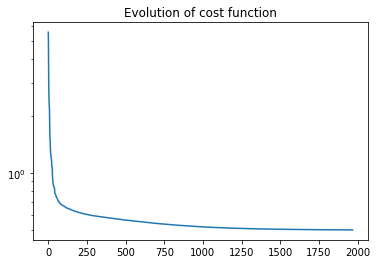

In [99]:
print(len(l))
plt.plot(l)
plt.yscale("log")
plt.title("Evolution of cost function")

Text(0.5, 1.0, 'Evolution of number of points in mask')

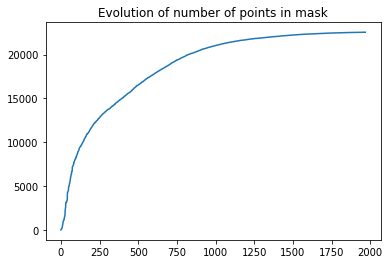

In [100]:
plt.plot(npoints)
plt.title("Evolution of number of points in mask")
#plt.savefig("Upper_level_tests_results/full_pen.png")

In [101]:
pysap.Image(data=np.reshape(res.x,u0.shape)).show()